# Промежуточный проект по модулю "Построение модели"

## Бизнес-анализ

Мы владеем сетью магазинов, в которых продаются различные товары. 
Наши сотрудники собрали датасет из 8523 продаж товаров в различных магазинах нашей сети. 
Наша задача построить модель, предсказывающую продажи каждого продукта в конкретном магазине. 
Используя эту модель, попробовать выявить факторы, больше всего влияющие на увеличение продаж. 

## Анализ данных

In [1]:
# подключение библиотек
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

### Загрузка и оценка качества данных

In [2]:
# загрузка данных
df = pd.read_csv('data.csv')
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


Описание датасета:

Item_Identifier -	Id продукта

Item_Weight -	Вес продукта

Item_Fat_Content -	Содержание жира в продукте

Item_Visibility -	%полок, отведенный под наш продукт в конкретном магазине

Item_Type -	Категория продукта

Item_MRP -	Максимальная цена продажи продукта

Outlet_Identifier -	Идентификатор магазина

Outlet_Establishment_Year -	Год открытия магазина

Outlet_Size -	Площадь магазина

Outlet_Location_Type -	Тип города, в котором расположен магазин

Outlet_Type -	Признак является ли магазин продуктовым или супермаркетом

Item_Outlet_Sales -	Продажи продукта в конкретном магазине. Именно ее и надо предсказывать

In [4]:
# общая информация
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              8523 non-null object
Item_Weight                  7060 non-null float64
Item_Fat_Content             8523 non-null object
Item_Visibility              8523 non-null float64
Item_Type                    8523 non-null object
Item_MRP                     8523 non-null float64
Outlet_Identifier            8523 non-null object
Outlet_Establishment_Year    8523 non-null int64
Outlet_Size                  6113 non-null object
Outlet_Location_Type         8523 non-null object
Outlet_Type                  8523 non-null object
Item_Outlet_Sales            8523 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.1+ KB


Видим два признака с пропущенными значениями; половина признаков - категориальные. Пропуски необходимо заполнить и привести переменные к числовому формату.

### Изучение корреляционных связей и выбросов

Чтобы оценить тесноту корреляционных связей и посторить диаграмму распределения, оценить выбросы в данных создадим копию датасета, признаки преобразуем в числовые пока с помощью LabelEncoder

In [9]:
df_copy = df.copy()
le_copy = LabelEncoder()
df_copy['Item_Identifier'] = le_copy.fit_transform(df_copy['Item_Identifier'])
df_copy['Item_Fat_Content'] = le_copy.fit_transform(df_copy['Item_Fat_Content'])
df_copy['Item_Type'] = le_copy.fit_transform(df_copy['Item_Type'])
df_copy['Outlet_Size'] = df_copy['Outlet_Size'].fillna('Medium')
df_copy['Outlet_Size'] = le_copy.fit_transform(df_copy['Outlet_Size'])
df_copy['Outlet_Identifier'] = le_copy.fit_transform(df_copy['Outlet_Identifier'])
df_copy['Outlet_Location_Type'] = le_copy.fit_transform(df_copy['Outlet_Location_Type'])
df_copy['Outlet_Type'] = le_copy.fit_transform(df_copy['Outlet_Type'])

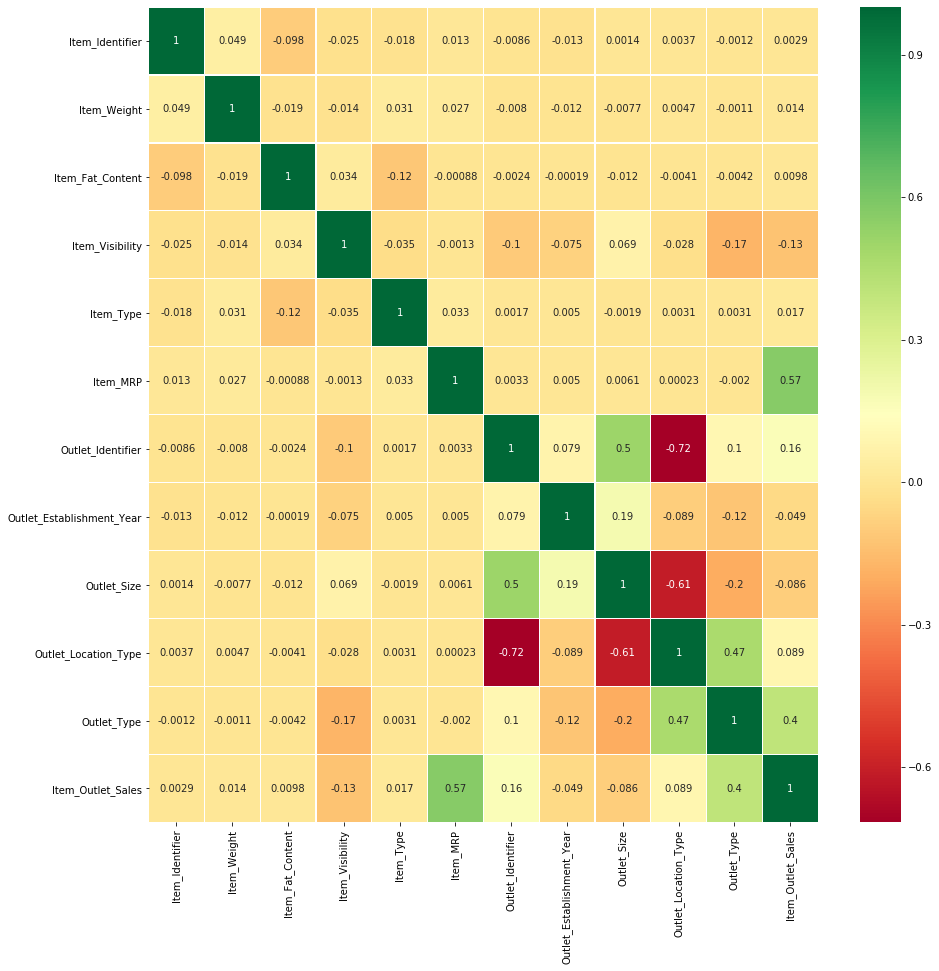

In [6]:
# строим матрицу корреляций
sns.heatmap(df_copy.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(15,15)
plt.show()

Как видно, очень тесных линейных взаимосвязей как между самими признаками, так и между признаками и целевой переменной нет. Скорее всего, линейная модель прогнозирования продаж товаров будет не слишком точна.

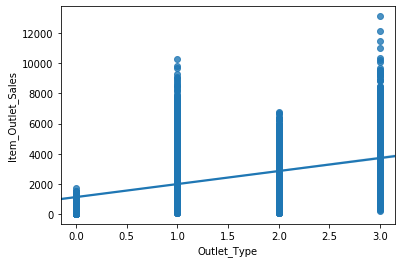

In [16]:
# визуализируем несколько линейных отношений с наибольшими коэффициентами корреляции
# продажи и тип магазина
sns.regplot(x=df_copy.Outlet_Type, y=df_copy.Item_Outlet_Sales, fit_reg=True)

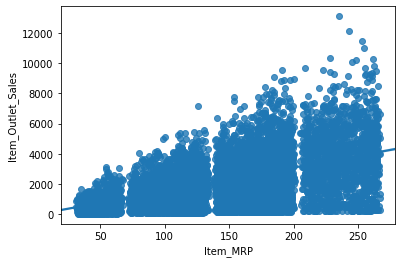

In [15]:
# продажи и максимальная цена продукта
sns.regplot(x=df_copy.Item_MRP, y=df_copy.Item_Outlet_Sales, fit_reg=True)

Слабые линейные взаимосвязи, при обучении предпочтение будем отдавать нелинейным моделям.

In [10]:
# основные статистические показатели
df_copy.describe()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
count,8523.000000,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,779.714889,12.857645,1.369354,0.066132,7.226681,140.992782,4.722281,1997.831867,1.170832,1.112871,1.201220,2181.288914
std,449.222377,4.643456,0.644810,0.051598,4.209990,62.275067,2.837201,8.371760,0.600327,0.812757,0.796459,1706.499616
min,0.000000,4.555000,0.000000,0.000000,0.000000,31.290000,0.000000,1985.000000,0.000000,0.000000,0.000000,33.290000
25%,395.500000,8.773750,1.000000,0.026989,4.000000,93.826500,2.000000,1987.000000,1.000000,0.000000,1.000000,834.247400
50%,783.000000,12.600000,1.000000,0.053931,6.000000,143.012800,5.000000,1999.000000,1.000000,1.000000,1.000000,1794.331000
75%,1167.000000,16.850000,2.000000,0.094585,10.000000,185.643700,7.000000,2004.000000,2.000000,2.000000,1.000000,3101.296400
max,1558.000000,21.350000,4.000000,0.328391,15.000000,266.888400,9.000000,2009.000000,2.000000,2.000000,3.000000,13086.964800


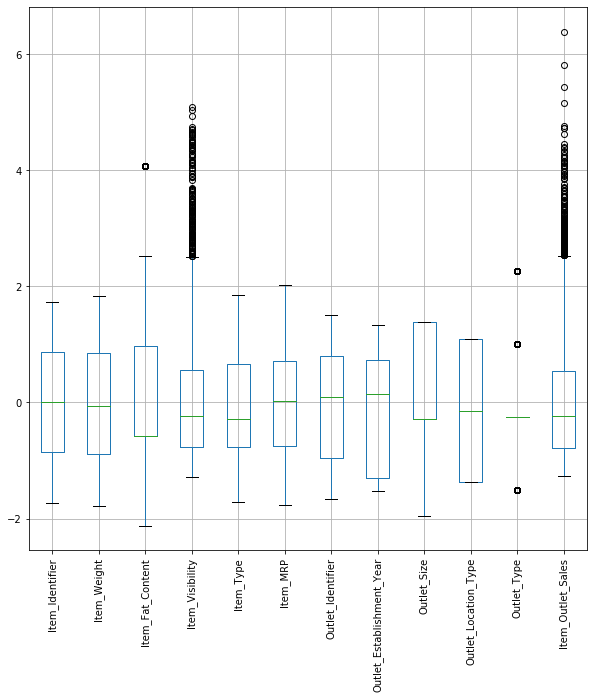

In [7]:
# масштабируем признаки и выводим диаграммы распределения
sc = StandardScaler()
df_copy = sc.fit_transform(df_copy)
df_copy = pd.DataFrame(df_copy, columns=df.columns)

df_copy.boxplot(rot=90, figsize=(10,10))

Видим выброс в жирности продукта, признак категориальный, смотрим на значения.

In [3]:
df.Item_Fat_Content.unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

Значения по-разному записаны, но по сути их два. Приведем значения к единому формату записи.

In [4]:
fat = {'low fat': 'Low Fat', 'LF': 'Low Fat', 'reg': 'Regular', 'Low Fat': 'Low Fat', 'Regular': 'Regular'}
df.Item_Fat_Content = df.Item_Fat_Content.map(fat)

Процент полок, отведенный под продукт, более 30% кажется странным, но допустим, что это маленький продуктовый магазин с ограниченным выбором товаров.

## Подготовка данных

### Устранение пропущенных значений

Вернемся к исходному датафрейму и подготовим данные для обучения.

In [5]:
# заменим пропущенные значения с помощью KNN
# 'Item_Weight'
imputer = KNNImputer(n_neighbors=3)
df_w = imputer.fit_transform(df[['Item_Weight']])
df['Item_Weight'] = df_w

In [6]:
# 'Outlet_Size'
# сначала преобразуем к числовому типу
outlet_size_dict = {'Medium':1, 'High':2, 'Small':0}
df['Outlet_Size'] = df['Outlet_Size'].map(outlet_size_dict)

In [7]:
df_s = imputer.fit_transform(df[['Outlet_Size']])
df['Outlet_Size'] = df_s

### Обработка категориальных признаков

In [8]:
# смотрим на разнооообразие в катеригориальных переменных
df.describe(include=object)

,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Location_Type,Outlet_Type
count,8523,8523,8523,8523,8523,8523
unique,1559,2,16,10,3,4
top,FDG33,Low Fat,Fruits and Vegetables,OUT027,Tier 3,Supermarket Type1
freq,10,5517,1232,935,3350,5577


Разнообразие признаков не слишком велико, воспользуемся OneHotEncoding для преобразования к числовому типу.

In [11]:
# OneHotEncoding
df.describe(include=object).columns

Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

In [12]:
df_dumm = pd.get_dummies(df, columns=['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Type'])
df_dumm.head(2)

,Item_Identifier,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Item_Outlet_Sales,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,...,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,156,9.30,0.016047,249.8092,1999,1.0,3735.1380,1,0,0,...,0,0,1,1,0,0,0,1,0,0
1,8,5.92,0.019278,48.2692,2009,1.0,443.4228,0,1,0,...,0,0,0,0,0,1,0,0,1,0


## Моделирование

### Выбор и обоснование метрики для оценки качества модели

Т.к. мы работаем с задачей регрессии, то для оценки качества модели выберем абсолютную ошибку (MАE), сумма разницы истинного и предсказанного значений по модулю. Она всегда положительна и в отличие от среднеквадратичной ошибки отсутсвует штраф за величину отдельной ошибки. Соответственно, чем меньше ошибка, тем лучше модель.

### Разделение данных на тренировочные и тестовые и стандартизация

In [13]:
df_dumm.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Item_Outlet_Sales',
       'Item_Fat_Content_Low Fat', 'Item_Fat_Content_Regular',
       'Item_Type_Baking Goods', 'Item_Type_Breads', 'Item_Type_Breakfast',
       'Item_Type_Canned', 'Item_Type_Dairy', 'Item_Type_Frozen Foods',
       'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks',
       'Item_Type_Health and Hygiene', 'Item_Type_Household', 'Item_Type_Meat',
       'Item_Type_Others', 'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
       'Outlet_Identifier_OUT010', 'Outlet_Identifier_OUT013',
       'Outlet_Identifier_OUT017', 'Outlet_Identifier_OUT018',
       'Outlet_Identifier_OUT019', 'Outlet_Identifier_OUT027',
       'Outlet_Identifier_OUT035', 'Outlet_Identifier_OUT045',
       'Outlet_Identifier_OUT046', 'Outlet_Identifier_OUT049',
       'Outlet_Location_Type_Tier 1', 'Outlet_Locat

In [14]:
# формируем признаки и целевую переменную
X = df_dumm[['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Outlet_Size',
       'Item_Fat_Content_Low Fat', 'Item_Fat_Content_Regular',
       'Item_Type_Baking Goods', 'Item_Type_Breads', 'Item_Type_Breakfast',
       'Item_Type_Canned', 'Item_Type_Dairy', 'Item_Type_Frozen Foods',
       'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks',
       'Item_Type_Health and Hygiene', 'Item_Type_Household', 'Item_Type_Meat',
       'Item_Type_Others', 'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
       'Outlet_Identifier_OUT010', 'Outlet_Identifier_OUT013',
       'Outlet_Identifier_OUT017', 'Outlet_Identifier_OUT018',
       'Outlet_Identifier_OUT019', 'Outlet_Identifier_OUT027',
       'Outlet_Identifier_OUT035', 'Outlet_Identifier_OUT045',
       'Outlet_Identifier_OUT046', 'Outlet_Identifier_OUT049',
       'Outlet_Location_Type_Tier 1', 'Outlet_Location_Type_Tier 2',
       'Outlet_Location_Type_Tier 3', 'Outlet_Type_Grocery Store',
       'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2',
       'Outlet_Type_Supermarket Type3']]
y = df_dumm.Item_Outlet_Sales

In [15]:
# разделяем на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [16]:
# стандартизируем
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Обучим модель линейной регрессии

За базовый метод возьмем линейную регрессию

In [28]:
from sklearn.linear_model import LinearRegression

In [30]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [34]:
# оценим модель
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, lr.predict(X_test))

841.5255781982044

In [35]:
# подберем параметры
from sklearn.model_selection import GridSearchCV
param = {'normalize':['True', 'False']}
gs = GridSearchCV(LinearRegression(), param_grid = param, cv = 5, scoring = 'neg_mean_absolute_error', n_jobs=-1)
gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'normalize': ['True', 'False']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_absolute_error', verbose=0)

In [36]:
gs.best_estimator_

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize='True')

In [38]:
lreg = LinearRegression(normalize=True)
lreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [39]:
mean_absolute_error(y_test, lreg.predict(X_test))

840.1026034736258

Подбор параметров не дал улучшения результата

### Обучим модель Ridge регрессии

Обучим Ridge регрессию, штрафуюшую за большие коэффициенты и сравним с обычной регрессией.

In [42]:
from sklearn.linear_model import Ridge
regr = Ridge()
regr.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [18]:
# оценим модель
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, regr.predict(X_test))

840.6613498987176

In [32]:
# подберем параметры
from sklearn.model_selection import GridSearchCV
param = {'alpha': [1e-3, 1e-2, 1e-1, 1, 10], 'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}
gs = GridSearchCV(Ridge(), param_grid = param, cv = 5, scoring = 'neg_mean_absolute_error', n_jobs=-1)
gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10],
                         'solver': ['auto', 'svd', 'cholesky', 'lsqr',
                                    'sparse_cg', 'sag', 'saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_absolute_error', verbose=0)

In [23]:
gs.best_estimator_

Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='sag', tol=0.001)

In [33]:
reg = Ridge(alpha=10, solver='sag')
reg.fit(X_train, y_train)

Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='sag', tol=0.001)

In [27]:
mean_absolute_error(y_test, reg.predict(X_test))

840.6173800473975

Ridge регрессия не улучшила результат.

### Обучим "случайный лес"

Среди нелинейных моделей попробуем случайный лес, один из лучших ансамблевых алгоритмов.

In [41]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor()
clf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [43]:
# оценим модель
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, clf.predict(X_test))

788.7993335870967

По сравнению с линейной моделью результат лучше.

In [46]:
# подберем параметры
from sklearn.model_selection import RandomizedSearchCV
param = {'n_estimators': list(range(2, 101)), 'max_depth': list(range(2, 16)), 'max_leaf_nodes': list(range(2, 51))}
gs = RandomizedSearchCV(RandomForestRegressor(), param_distributions = param, cv = 5, scoring = 'neg_mean_absolute_error', n_jobs=-1)
gs.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [47]:
gs.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=9, max_features='auto', max_leaf_nodes=28,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=31, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [48]:
clf_cv = RandomForestRegressor(max_depth=9, max_leaf_nodes=28, n_estimators=31)
clf_cv.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=9, max_features='auto', max_leaf_nodes=28,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=31, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [49]:
# оценим модель
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, clf_cv.predict(X_test))

758.8502778560729

Подбор параметров позволил улучшить результат модели, данная модель является наилучшей из рассмотренных.

### Определим признаки, наиболее влияющие на объемы продаж

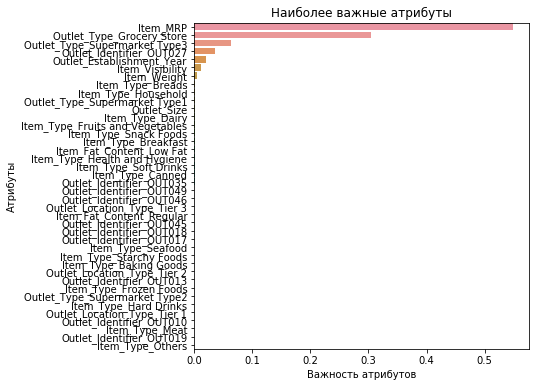

In [50]:
feature_imp = pd.Series(clf_cv.feature_importances_,index=list(X.columns)).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(6, 6))
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Важность атрибутов')
plt.ylabel('Атрибуты')
plt.title('Наиболее важные атрибуты')
plt.show()

На продажи наибольшее влияние оказывают: максимальная цена продукта и то, относится ли магазин к одному из двух типов - Grocery Store or Supermarket Type 3. Данные признаки по таблице корреляции также имели наибольшие коэффициенты по взаимосвязи с целевой переменной.

### Проведем стекинг нескольких моделей

In [54]:
from sklearn.ensemble import StackingRegressor
estimators = [('r', Ridge()), ('lr', LinearRegression())]
reg_st = StackingRegressor(estimators=estimators, final_estimator=RandomForestRegressor(max_depth=9, max_leaf_nodes=28, n_estimators=31))
reg_st.fit(X_train, y_train)

StackingRegressor(cv=None,
                  estimators=[('r',
                               Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                                     max_iter=None, normalize=False,
                                     random_state=None, solver='auto',
                                     tol=0.001)),
                              ('lr',
                               LinearRegression(copy_X=True, fit_intercept=True,
                                                n_jobs=None,
                                                normalize=False))],
                  final_estimator=RandomForestRegressor(bootstrap=True,
                                                        ccp_alpha=0.0,
                                                        criterion='mse',
                                                        max_depth=9,
                                                        max_features='auto',
                                                        m

In [55]:
# оценим модель
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, reg_st.predict(X_test))

796.4301385423311

Ошибка модели стекинга выше, чем у просто "случайного леса".

## Вывод

Выполнен предварительный анализ признаков, их влияния на целевую перемнную. Проведена предобработка данных и обучение моделей: линейной и нелинейной. Выполнена оценка качества моделей в соответствии с заранее определенным критерием. Наилучший результат дала модель, обученная с помощью алгоритма "Случайный лес".